lectures:
* Dhanshree Arora on overall architecture [Jupyter - Under the Hood](https://www.youtube.com/watch?v=i22DZplhHCY)
* David Brochart on [Jupyter Server](https://www.youtube.com/watch?v=pZC4V8xmsLE) and [Collaborative editing in Jupyter](https://www.youtube.com/watch?v=VXXLnmGqAO4)


In [1]:
%%HTML
<iframe width="240" height="150" src="https://www.youtube.com/embed/i22DZplhHCY" title="Jupyter - Under the Hood - presented by Dhanshree Arora" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>
<iframe width="240" height="150" src="https://www.youtube.com/embed/pZC4V8xmsLE" title="David Brochart   Jupyter Server—the workhorse that drives nearly all Jupyter web applications | Jupy" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>
<iframe width="240" height="150" src="https://www.youtube.com/embed/VXXLnmGqAO4" title="David Brochart - Collaborative editing in Jupyter | PyData Paris 2024" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

## Connecting to server API

In [4]:
!jupyter server list --jsonlist

[
  {
    "base_url": "/",
    "hostname": "localhost",
    "password": false,
    "pid": 368763,
    "port": 8888,
    "root_dir": "/home/beni/WM",
    "secure": false,
    "sock": "",
    "token": "f246a5ae1fab9d6a88e9bfe6c930a9bb22f21c6ba8c2e8e4",
    "url": "http://localhost:8888/",
    "version": "2.15.0"
  }
]


In [5]:
# Or we can directly call the code implementing `jupyter server list`:
# https://github.com/jupyter-server/jupyter_server/blob/main/jupyter_server/serverapp.py
# It reads `jpserver-*.json` files and does some sanity checks to filter live servers.
import jupyter_server.serverapp
servers = list(jupyter_server.serverapp.list_running_servers())
servers

[{'base_url': '/',
  'hostname': 'localhost',
  'password': False,
  'pid': 368763,
  'port': 8888,
  'root_dir': '/home/beni/WM',
  'secure': False,
  'sock': '',
  'token': 'f246a5ae1fab9d6a88e9bfe6c930a9bb22f21c6ba8c2e8e4',
  'url': 'http://localhost:8888/',
  'version': '2.15.0'}]

In [6]:
import json, urllib.request

def url(serv, api_path):
    return serv['url'].rstrip('/') + api_path + '?token=' + serv['token']

[url(s, '/api/sessions') for s in servers]

['http://localhost:8888/api/sessions?token=f246a5ae1fab9d6a88e9bfe6c930a9bb22f21c6ba8c2e8e4']

In [7]:
def api_sessions(serv):
    return json.load(urllib.request.urlopen(url(serv, '/api/sessions')))

api_sessions(servers[0])

[{'id': 'e2a0720a-d695-43f8-be7e-ec635f44477c',
  'path': 'newm-atha/HANDOFF.ipynb',
  'name': 'HANDOFF.ipynb',
  'type': 'notebook',
  'kernel': {'id': '118d4b89-b22f-424d-8b5e-c8998db671c4',
   'name': 'python3',
   'last_activity': '2025-04-23T10:14:58.110645Z',
   'execution_state': 'idle',
   'connections': 4},
  'notebook': {'path': 'newm-atha/HANDOFF.ipynb', 'name': 'HANDOFF.ipynb'}},
 {'id': 'a8277f8e-1daf-4b68-bc6e-c49b1fb78149',
  'path': 'newm-atha/NEWM.ipynb',
  'name': 'NEWM.ipynb',
  'type': 'notebook',
  'kernel': {'id': '9103b766-1f99-4fc5-88e8-2a7f3ff219f0',
   'name': 'python3',
   'last_activity': '2025-04-23T11:22:50.167444Z',
   'execution_state': 'idle',
   'connections': 1},
  'notebook': {'path': 'newm-atha/NEWM.ipynb', 'name': 'NEWM.ipynb'}},
 {'id': '4a8cf496-6bc0-42b0-b5cf-8a6e2770c388',
  'path': 'newm-atha/KERNELS.ipynb',
  'name': 'KERNELS.ipynb',
  'type': 'notebook',
  'kernel': {'id': '72108b28-6b81-430f-a985-a77dc2c74c5f',
   'name': 'python3',
   'las

# Kernels may run under sessions, but may also run independently
To illustrate the differences in diagrams below, I'm concurrently running:

1. A `jupyter console`.  
   Launches a kernel subprocess which listens on zeromq — has a connection file, but not known to any server's /api, so can be joined by `jupyter console --existing` but can NOT be used be notebooks.
    * Normally the parent process picks zeromq ports, [writes](https://github.com/jupyter/jupyter_client/blob/6ea834d69d9404b9b67fbc066ee8bdf1d7d2ede6/jupyter_client/provisioning/local_provisioner.py#L191-L195) a [kernel-{PID}.json connection file](https://github.com/jupyter/jupyter_client/blob/6ea834d69d9404b9b67fbc066ee8bdf1d7d2ede6/jupyter_client/consoleapp.py#L136), passes it to child (per `-f {connection_file}` in kernelspec template), owns and [cleans up](https://github.com/jupyter/jupyter_client/blob/6ea834d69d9404b9b67fbc066ee8bdf1d7d2ede6/jupyter_client/connect.py#L493).  (If you kill parent, file may be left behind.)
    * subprocess has fallback logic to [create and cleanup](https://github.com/ipython/ipykernel/blob/83b51a60fcba003556a23322cb8c154fa27a8de2/ipykernel/kernelapp.py#L319-L322) connection files, but that I think is only for manual use (`python -m ipykernel` prints on stdout how to connect).

2. An `ipython`.  
   Uses ipykernel code in-process, no zeromq sockets, no connection file.

Notebook servers use similar jupyter_client logic to write a [kernel-{UUID}.json connection file](https://github.com/jupyter/jupyter_client/blob/6ea834d69d9404b9b67fbc066ee8bdf1d7d2ede6/jupyter_client/multikernelmanager.py#L209) to runtime/ dir and launch kernel subprocess,  
but they _also_ advertise the kernel in their HTTP /api/kernels, AND proxy websocket<->zeromq, allowing browser use.

In [8]:
import subprocess, time
console_term = subprocess.Popen(['xterm', '-e', 'jupyter', 'console', '--debug'])
ipython_term = subprocess.Popen(['xterm', '-e', 'ipython', '--debug'])
time.sleep(2) 

In [9]:
# Kernels managed by the server:
def api_kernels(serv):
    return json.load(urllib.request.urlopen(url(serv, '/api/kernels')))

for serv in servers:
    # comparing ids, some other fields may vary, notably 'last_activity'.
    session_kernel_ids = {s['kernel']['id'] for s in api_sessions(serv)}
    kernel_ids = {k['id'] for k in api_kernels(serv)}
    assert session_kernel_ids == kernel_ids

api_kernels(servers[0])

[{'id': '118d4b89-b22f-424d-8b5e-c8998db671c4',
  'name': 'python3',
  'last_activity': '2025-04-23T10:14:58.110645Z',
  'execution_state': 'idle',
  'connections': 4},
 {'id': '9103b766-1f99-4fc5-88e8-2a7f3ff219f0',
  'name': 'python3',
  'last_activity': '2025-04-23T11:22:50.167444Z',
  'execution_state': 'idle',
  'connections': 1},
 {'id': '72108b28-6b81-430f-a985-a77dc2c74c5f',
  'name': 'python3',
  'last_activity': '2025-04-23T11:23:53.344807Z',
  'execution_state': 'busy',
  'connections': 1}]

In [ ]:
# https://discourse.jupyter.org/t/how-to-get-kernel-state-from-running-local-jupyter-notebook/15028/4
# cf. also `find_connection_file()` in https://github.com/jupyter/jupyter_client/blob/main/jupyter_client/connect.py
import jupyter_core, jupyter_client, pathlib
rt_dir = pathlib.Path(jupyter_core.paths.jupyter_runtime_dir())
conn_files = list(rt_dir.glob("kernel-*.json"))
conn_files

In [11]:
import ipykernel
this_kernel_file = pathlib.Path(ipykernel.get_connection_file())
# RuntimeError if not running under ipykernel
assert this_kernel_file in conn_files
this_kernel_file

PosixPath('/home/beni/.local/share/jupyter/runtime/kernel-72108b28-6b81-430f-a985-a77dc2c74c5f.json')

### Connection file content don't include `id` like API — instead the ID appears in the file name!  
(they have 'key' which is unrelated).  
See also https://gist.github.com/minrk/e49fb6c06ac2e45eb4fe32135671634b on correlating files & processes.

In [12]:
def kernel_id_from_file(f: pathlib.Path):
    return f.stem.replace('kernel-', '')

this_kernel_id = kernel_id_from_file(this_kernel_file)

In [13]:
def kernels_infos():
    """Kernel connection infos, from connection files, may include dead kernels."""
    conn_files = list(rt_dir.glob("kernel-*.json"))
    return {kernel_id_from_file(f): json.load(open(f)) for f in conn_files}
    
kernels_infos()

{'327856': {'shell_port': 40405,
  'iopub_port': 43905,
  'stdin_port': 32937,
  'control_port': 36113,
  'hb_port': 36171,
  'ip': '127.0.0.1',
  'key': 'ab505fa7-6a4c50ad9f318d7e3a004202',
  'transport': 'tcp',
  'signature_scheme': 'hmac-sha256',
  'kernel_name': ''},
 '118d4b89-b22f-424d-8b5e-c8998db671c4': {'shell_port': 55453,
  'iopub_port': 43049,
  'stdin_port': 48923,
  'control_port': 56435,
  'hb_port': 55391,
  'ip': '127.0.0.1',
  'key': '92bd466c-933ba0099f222407279b193d',
  'transport': 'tcp',
  'signature_scheme': 'hmac-sha256',
  'kernel_name': 'python3',
  'jupyter_session': '/home/beni/WM/newm-atha/HANDOFF.ipynb'},
 '9103b766-1f99-4fc5-88e8-2a7f3ff219f0': {'shell_port': 33825,
  'iopub_port': 45903,
  'stdin_port': 37911,
  'control_port': 42115,
  'hb_port': 56937,
  'ip': '127.0.0.1',
  'key': '5a633538-ebc3987e062dd837ffb6a1c5',
  'transport': 'tcp',
  'signature_scheme': 'hmac-sha256',
  'kernel_name': 'python3',
  'jupyter_session': '/home/beni/WM/newm-atha/NEW

In [14]:
import psutil

In [15]:
serv_process = psutil.Process(serv['pid'])
print(serv_process.cmdline())
print(serv_process.parent())
{c.pid: ' '.join(c.cmdline()) for c in serv_process.children()}

['/home/beni/.cache/uv/archive-v0/8wgqDnHJf0aB-j3d2GoEc/bin/python', '/home/beni/.cache/uv/archive-v0/8wgqDnHJf0aB-j3d2GoEc/bin/jupyter-lab']
psutil.Process(pid=368710, name='uv', status='sleeping', started='2025-04-21 13:01:54')


{389839: '/home/beni/.cache/uv/archive-v0/8wgqDnHJf0aB-j3d2GoEc/bin/python -m ipykernel_launcher -f /home/beni/.local/share/jupyter/runtime/kernel-118d4b89-b22f-424d-8b5e-c8998db671c4.json',
 389842: '/home/beni/.cache/uv/archive-v0/8wgqDnHJf0aB-j3d2GoEc/bin/python -m ipykernel_launcher -f /home/beni/.local/share/jupyter/runtime/kernel-9103b766-1f99-4fc5-88e8-2a7f3ff219f0.json',
 666998: '/home/beni/.cache/uv/archive-v0/8wgqDnHJf0aB-j3d2GoEc/bin/python -m ipykernel_launcher -f /home/beni/.local/share/jupyter/runtime/kernel-72108b28-6b81-430f-a985-a77dc2c74c5f.json'}

In [37]:
# Find processes by kernel ID appearing on command line (as part of file name — at least for ipykernel)
def kernel_procs_by_kid():
    kernels = kernels_infos()
    procs_by_kid = {}
    for p in psutil.process_iter(attrs=['cmdline', 'name', 'pid']):
        cmdline = p.info['cmdline'] or [p.info['name']] # fallback for zombie processes
        for k in kernels:
            if k in ''.join(cmdline):
                procs_by_kid[k] = p
    return procs_by_kid

kernel_procs_by_kid()

{'118d4b89-b22f-424d-8b5e-c8998db671c4': psutil.Process(pid=389839, name='python', status='sleeping', started='2025-04-21 20:12:24'),
 '9103b766-1f99-4fc5-88e8-2a7f3ff219f0': psutil.Process(pid=389842, name='python', status='sleeping', started='2025-04-21 20:12:24'),
 '72108b28-6b81-430f-a985-a77dc2c74c5f': psutil.Process(pid=666998, name='python', status='running', started='14:23:33')}

## Talk to a kernel

In [ ]:
client = jupyter_client.AsyncKernelClient()
client.load_connection_file(conn_files[1])

#print(await client.comm_info(reply=True))

# https://stackoverflow.com/a/79339022/
def output_hook(msg):
    print(msg['msg_type'], msg['content'])
#reply = await client.execute_interactive(code='''2+2''', output_hook=output_hook)

# Putting it all together => Diagram! 🍰

In [ ]:
def Mermaid(text_or_pieces):
    # official way is being discussed https://github.com/ipython/ipython/issues/14319
    # but for now use markdown.
    from IPython.display import Markdown
    return Markdown(f'```mermaid\n{flatten(text_or_pieces)}\n```')

def flatten(text_or_pieces, _indent=''):
    """Join strings with newlines, flatten nested arrays/iterators with indentation.
    
    Makes it simpler to template diagram structure with functions calling functions."""
    match text_or_pieces:
        case str(text):
            return _indent + text
        case pieces: # assume list/iterable
            return '\n'.join(flatten(p, _indent + '  ') for p in pieces)

import re
def node_id(txt):
    return re.sub(r'[^A-Za-z0-9]+', '_', txt)

def node(txt, open="([", close="])"):
    """Safe to use repeatedly - if same node is listed with last text wins."""
    return f'{node_id(txt)}{open}"{txt}"{close}'

Mermaid([
    'graph LR',
    [f'chicken --> {node("An egg")} --> chicken'],
])


In [ ]:
for p in psutil.process_iter(attrs=['cmdline', 'pid']):
    if p.info['cmdline'] and 'jupy' in p.info['cmdline'][0]:
        print(p.info)

In [ ]:
def diagram():
    import re, shlex

    visited_procs = set()

    def proc_text(proc: psutil.Process, body=[]):
        if proc.pid in visited_procs:
            return
        visited_procs.add(proc.pid)
        cmd = "<br>".join(shlex.quote(w) for w in proc.cmdline())
        yield f'subgraph pid{proc.pid} ["pid {proc.pid}"]'
        yield [f'cmd{proc.pid}["{cmd}"]', f'style cmd{proc.pid} stroke-width:0,fill:none']
        yield body
        yield f'end'
        # link from parent
        if proc.parent():
            yield f'pid{proc.parent().pid} --> pid{proc.pid}'
            #yield proc_text(proc.parent())
        # yield [proc_text(p) for p in proc.children()]

    procs_by_kid = kernel_procs_by_kid()
    
    def kernel_text(k_id, k):
        id = node_id(f"Kernel {k_id}")
        txt = f"kernel {k_id}<br>{k.get('kernel_name')}<br>jupyter_session: {k.get('jupyter_session')}"
        if k_id == this_kernel_id:
            txt = "This " + txt
        body = [id + '{{"' + txt + '"}}']
        if k_id == this_kernel_id:
            body += [f'style {id} stroke-width:3px']
        if k_id in procs_by_kid:
            yield proc_text(procs_by_kid[k_id], body)
            yield proc_text(procs_by_kid[k_id].parent())
        else:
            return body
    
    def session_text(s):
        if re.match(r'^[-0-9a-f]{30,}$', s['path']):
            path = ''  # UUID
        else:
            path = s['path']
        #name = s['name'] if s['name'] != s['id'] else ''
        return f"""{node_id(f"Session {s['id']}")}(["Session {s['id']}<br>type: {s['type']}<br>name: {path}"])"""

    def session_link(s):
        kernel_node = node_id(f"Kernel {s['kernel']['id']}")
        session_node = node_id(f"Session {s['id']}")
        return f"""{node_id(f"Session {s['id']}")} -..- {kernel_node}"""
    
    def serv_text(serv):
        pid = serv['pid']
        yield proc_text(psutil.Process(pid), [
            f'subgraph api{pid} [API {serv["url"]}]',
            [f'style api{pid} rx:3ex,ry:3ex'],  # Rounded corners as API is conceptual (square = process).
            [session_text(s) for s in api_sessions(serv)],
            f'end',
        ])
        # Link sessions-kernels outside, to avoids pulling orphan kernel nodes into the subgraph
        for s in api_sessions(serv):
            yield session_link(s)

    yield '%%{init: {"flowchart": {"htmlLabels": false}} }%%' # mitigate long markdown disappearing https://github.com/mermaid-js/mermaid/issues/5785
    yield 'flowchart LR'
    yield [serv_text(s) for s in servers]
    yield [kernel_text(k_id, k) for k_id, k in kernels_infos().items()]
    # yield ['markdown["`/This **is** _Markdown_ -n --foo`"]']

print(flatten(diagram()))

In [ ]:
Mermaid(diagram())

# Create session
POST -> session created -> kernel gets provisioned -> response includes session & kernel info  
https://jupyter-server.readthedocs.io/en/latest/developers/architecture.html#create-session-workflow  
https://jupyter-server.readthedocs.io/en/latest/developers/rest-api.html#post--api-sessions

In [ ]:
session_to_create = {
    'type': 'notebook',
    'name': 'CreatedByAPI.ipynb',
    'path': './CreatedByAPI.ipynb',
    'kernel': {'name': 'python3'},
}
response = urllib.request.urlopen(urllib.request.Request(
    url(servers[0], '/api/sessions'), method='POST',
    headers={'Content-Type': 'application/json'},
    data=json.dumps(session_to_create).encode()
))
new_session = json.load(response)
new_session

In [ ]:
Mermaid(diagram())

In [ ]:
response = urllib.request.urlopen(urllib.request.Request(
    url(servers[0], f"/api/sessions/{new_session['id']}"), method='DELETE',
    headers={'Content-Type': 'application/json'},
))
response.code

## What happens when switching a notebook to a different kernel?

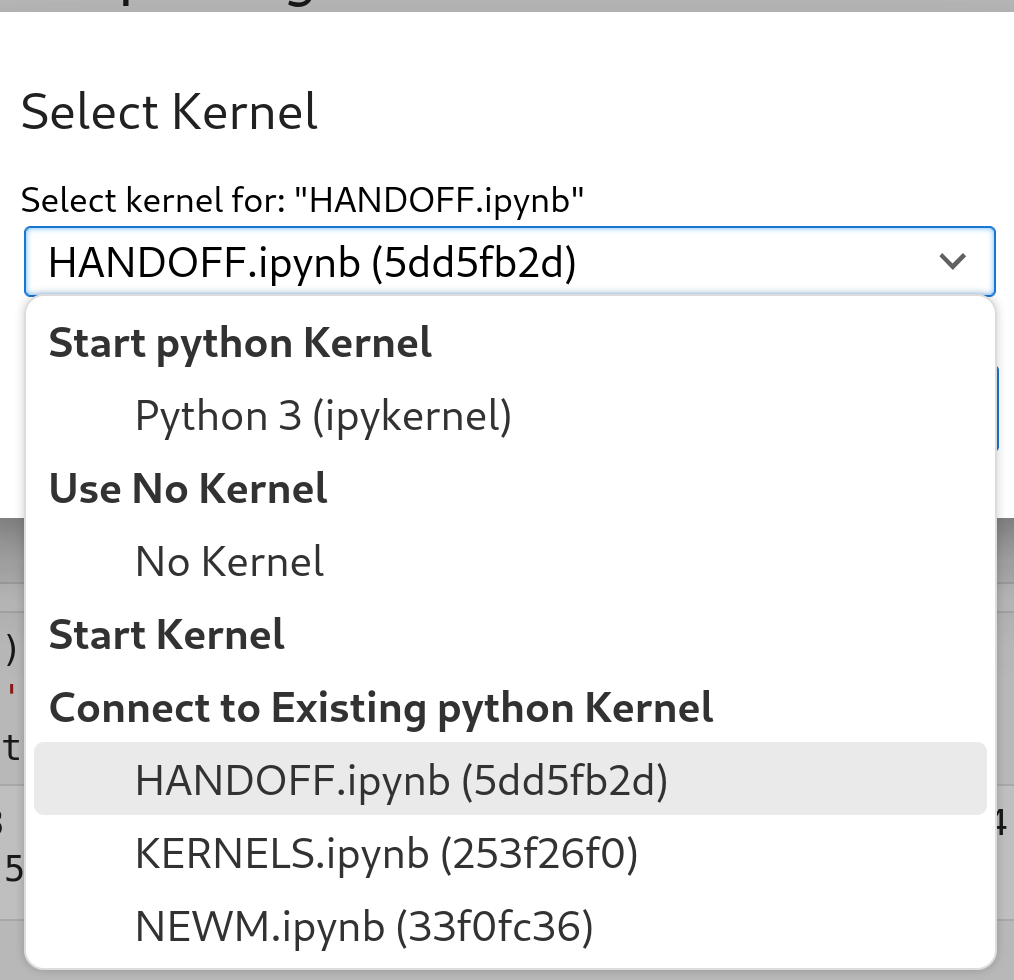

In [ ]:
Mermaid(diagram())

UI sends [PATCH /api/sessions/{id}](https://jupyter-server.readthedocs.io/en/latest/developers/rest-api.html#patch--api-sessions-session)
> URL: http://localhost:8888/api/sessions/d70204f2-ec94-47d9-aacd-a3dee4926ae0?1742395142370=  
> body: `{"kernel":{"id":"f51e3beb-69fe-4809-8aa6-e98adcae0359"},"id":"d70204f2-ec94-47d9-aacd-a3dee4926ae0"}`

referring to session which used to be:
```
{'id': 'd70204f2-ec94-47d9-aacd-a3dee4926ae0',
  'path': 'HANDOFF.ipynb',
  'name': 'HANDOFF.ipynb',
  'type': 'notebook',
  'kernel': {'id': 'ad58c9e0-f588-4a27-af90-cc6eda4304d5',
   'name': 'python3',
   'last_activity': '2025-03-19T11:24:01.445668Z',
   'execution_state': 'idle',
   'connections': 1},
  'notebook': {'path': 'HANDOFF.ipynb', 'name': 'HANDOFF.ipynb'}}
```

jupyter lab logs:
```
[I 2025-03-19 16:39:02.381 ServerApp] Kernel shutdown: ad58c9e0-f588-4a27-af90-cc6eda4304d5
[I 2025-03-19 16:39:02.814 ServerApp] Connecting to kernel f51e3beb-69fe-4809-8aa6-e98adcae0359.
```

* Shuts down old kernel without checking.  
  Switching HANDOFF.ipynb again shut down the shared kernel, leaving this KERNELS.ipynb with no kernel!

In [ ]:
kernels_infos()

In [ ]:
api_sessions(serv)

In [39]:
!xterm -fn Huge

xterm: cannot load font "Huge"
xterm: cannot load font "-adobe-courier-medium-r-normal--24-240-75-75-m-150-iso10646-1"


## Cleanup `jupyter console` and `ipython`
TODO: crude, leaves connection file around.  Opened https://github.com/jupyter/jupyter_console/issues/302  
TODO: correlate by kernel_procs_by_kid() and remove file? :-(

In [ ]:
import psutil, time
def kill_process(pid):
    try:
        p = psutil.Process(pid)
        print(f'killing {p.pid}: {p.cmdline()}')
        p.terminate()
        time.sleep(0.2)
        if p.is_running():
            p.kill()
    except psutil.ZombieProcess:
        print(f'zombie {p.pid}')
    print('->', psutil.wait_procs([p], timeout=0.2))

def kill_process_with_kernels(pid):
    for c in psutil.Process(pid).children(recursive=True):
        if c.is_running() and c.status() != psutil.STATUS_ZOMBIE and 'ipykernel_launcher' in c.cmdline():
            kill_process(c.pid)
    time.sleep(0.2)
    kill_process(pid)

In [ ]:
#kill_process_with_kernels(console_term.pid)
#kill_process_with_kernels(ipython_term.pid)

## ❓ I hear VSCode don't use jupyter server — how does their kernel lifecycle work then?

cf. https://github.com/microsoft/vscode-jupyter/issues/3998